# ZFOURGE SED Template Processing 
Using the generated ZFOURGE SED templates from the cdfs field, we explore how these SEDs will react in the UVJ colour space to see if the UVJ coordinates are still in the sample place.


In [551]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [552]:

# We are attempting to read in a new set of SEDs that have been generated using a variation of Michael's ZFOURGE SED processing code.
# the SEDs are in the form of csvs, this can be explored in the zfourge/seds
# directory. The csvs are in the form of:
# Wavelength (microns), Flux Density (10^-19erg_s_cm^2_Angstrom)

zfourge_folderpath = os.path.join('Eazy Template Extractions', 'zfourgeSEDs')
# We would like to create a function to read this in
def read_zfourge_template(folder_path, name):
    """_summary_

    Args:
        folder_path (string): path to the folder where the SED templates are located
        name (string): name of the object
    
    Returns:
        df: Returns a dataframe containing the SED template
        objname: Returns the name of the object
    """
    folder_path = os.path.join(folder_path)
    files_in_folder = os.listdir(folder_path)

    for file in files_in_folder:
        # Find filepath and convert to df
        
        # get rid of units in the filename
        objname = file.split('_units')[0]
        objname = objname.split('_')[1]
        if objname == name:
            filepath = os.path.join(folder_path, file)
            df = pd.read_csv(filepath)
            
            print(df)
            # our wavelength is in microns, convert to Angstroms
            
            # for the first column, we want to convert to Angstroms
            df.iloc[:, 0] = df.iloc[:, 0] 
            # Name each of the columns appropriately
            df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
            print(objname)
            return df, objname
        
    
    return None, None

df, objname = read_zfourge_template(zfourge_folderpath, '7544')

In [596]:
    
def read_zfourge_galaxy_templates(folder_path):
    """_summary_

        Args:
            folder_path (string): path to the folder where the SED templates are located
    
        Returns:
            df_list: Returns a list of dataframes containing the SED templates
            objname_list: Returns a list of the names of the objects
    """
    df_list = []
    objname_list = []
    folder_path = os.path.join(folder_path)
    files_in_folder = os.listdir(folder_path)
    i = 0
    
    for file in files_in_folder:

        # Find filepath and convert to df
        objname = file.split('_units')[0]
        objname = objname.split('_')[1]
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath)
        
        
        # check for infinities or null values and replace 
        if np.any(np.isnan(df)):
            df = df.replace([np.inf, -np.inf], np.nan)
        if np.any(np.isinf(df) ):
            df = df.replace([np.inf, -np.inf], np.nan)
        
        
        # Whereever there are NaN values, interpolate
        df = df.interpolate()
        
        # Convert microns to angstroms    
        df.iloc[:, 0] = df.iloc[:, 0]
        
        # name each of the columns appropriately
        df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
            
        # Append the dataframe to the list    
        df_list.append(df)
        objname_list.append(objname)
        
        
    return df_list, objname_list


In [597]:
# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')

# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

In [598]:
# In addition also use astSED to create filters
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)



In [599]:
# For plotting
# convert the passbands to arrays
U_arr = np.array(pb_U.asList())
V_arr = np.array(pb_V.asList())
J_arr = np.array(pb_J.asList())

In [600]:
# Read in all the ZFOURGE templates
df_list, objname_list = read_zfourge_galaxy_templates(zfourge_folderpath)

In [601]:
print(objname_list[2])

# count and print na
print("Number of NaN values in the dataframe: ", df_list[0].isna().sum().sum())

26789
Number of NaN values in the dataframe:  0


In [602]:

# we know where the NaN values are and we know what values come before and after
# so we can interpolate the values
df_list[0] = df_list[0]
print("Number of NaN values in the dataframe: ", df_list[0].isna().sum().sum())

Number of NaN values in the dataframe:  0


In [603]:
df_list[0][2000:2015]


,lambda (Angstroms),Total Flux (erg/s/cm^2/Angstrom)
2000,6568.4194,7.704046
2001,6568.8203,7.701735
2002,6569.2110,7.699425
2003,6569.6016,7.697115
2004,6570.0020,7.694804
2005,6570.3920,7.692494
2006,6570.7925,7.690183
2007,6571.1836,7.687873
2008,6571.5737,7.685563
2009,6571.9740,7.683252


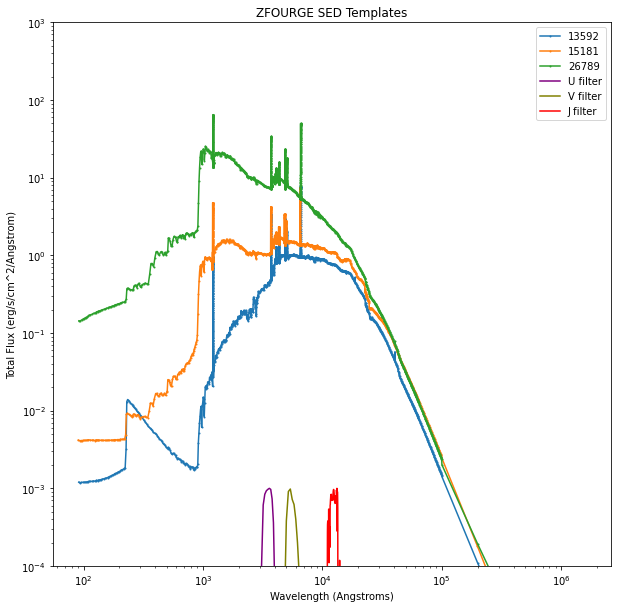

In [604]:
# Plot all of the SEDS

# for each sed, cut it so the wavelength is between 10^2 and 10^5
# then plot it
#for i in range(len(df_list)):
   # df_list[i] = df_list[i][(df_list[i]['lambda (Angstroms)'] > 10**2) & (df_list[i]['lambda (Angstroms)'] < 10**5)]


plt.figure(figsize=(10, 10))
for i in range(len(df_list)):
    plt.loglog(df_list[i].iloc[:, 0], df_list[i].iloc[:, 1], label=objname_list[i], marker='o', markersize=1)
#plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('ZFOURGE SED Templates')
sc = 10**-3
# additionally plot the relatively locations of the filters
plt.loglog(U_arr[:, 0], sc*U_arr[:,1], label='U filter', c='purple')
plt.loglog(V_arr[:, 0], sc*V_arr[:,1], label='V filter', c='olive')
plt.loglog(J_arr[:, 0], sc*J_arr[:,1], label='J filter', c='red')

plt.ylim(10**-4, 10**3)

plt.legend()

plt.show()




We can see a very very clear trend of the seds now being alligned in their rest frame. The lyman break is clearly visible and the absorption and emission lines are also very clear. This is a very good sign that the SEDs are being generated correctly.

In [605]:
# We now have some SED's that can be put through my fitting code to see how the UVJ diagram looks,
# and to see if it behaves as expected

# We will need to convert the SEDs to a format that can be used by the fitting code
# We can attempt to use the composite code, without the need for the SED fitting code
uv_colours = []
vj_colours = []

# for better coverage, create an AGN SED, combine them at 0% and have a look
agn_df, params = create_type1_skirtor_agn(skirtor_folderpath)


# alpha list
alpha_list = np.linspace(0, 1, 11)

#print(df_list[0])
# create a composite set
composite_df = create_composite_sed(agn_df, df_list[0], 0) # This is just for one, with no agn juice added
print(composite_df)

alpha_list = [0]

# Try now with a composite stack of seds
#df_list = generate_composite_set(agn_df, df_list, alpha_list)



      lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
0           9.111319e+01                      1.201676e-03
1           9.120108e+01                      1.201069e-03
2           9.411692e+01                      1.180927e-03
3           9.611941e+01                      1.191333e-03
4           9.812190e+01                      1.193698e-03
...                  ...                               ...
2915        1.201493e+06                      4.944719e-07
2916        1.258925e+06                      4.550188e-07
2917        1.401741e+06                      3.569122e-07
2918        1.445440e+06                      3.382190e-07
2919        1.601990e+06                      2.712501e-07

[2920 rows x 2 columns]


In [606]:
#df_list = df_list[0]

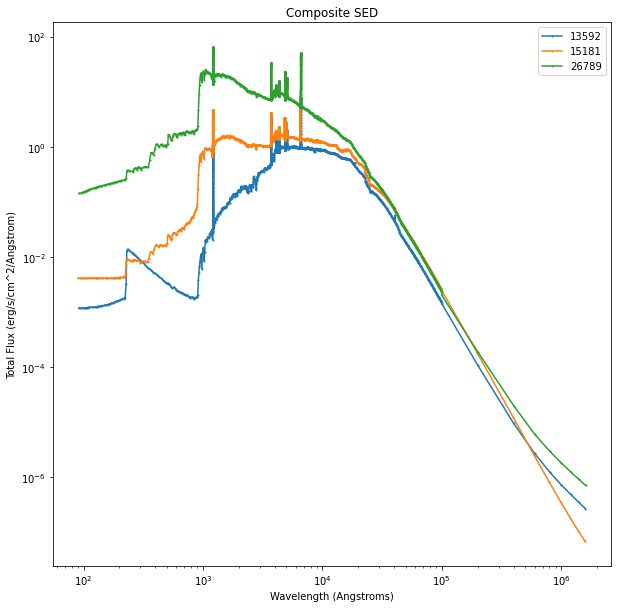

In [607]:

# Plot this
plt.figure(figsize=(10, 10))
#plt.loglog(composite_df.iloc[:, 0], composite_df.iloc[:, 1], label='Composite', marker='o', markersize=1)
# Plot agn normalized seds from the df_list
for i in range(0, len(df_list)):
    plt.loglog(df_list[i].iloc[:, 0], df_list[i].iloc[:, 1], label=objname_list[i], marker='o', markersize=1)


plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('Composite SED')
plt.legend()
plt.show()


In [612]:
uv_colours = []
vj_colours = []
bad_entries = []
new_objname_list = []
print(len(df_list))
for i, sed_data in enumerate(df_list):
    # Create an SED object using astSED    
    wl = sed_data['lambda (Angstroms)']
    fl = sed_data['Total Flux (erg/s/cm^2/Angstrom)']

    # We are using a restframe SED, so z = 0 - now atleast
    sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)    
    
    


    # # Try to calc uvj, if math domain error occurs, if bad SED, delete it
    # uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
    # vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
    # uv_colours.append(uv)
    # vj_colours.append(vj)
    
    # We assume there will be some bad SEDs
    # Try to create UVJ colours, and if it fails, remove the SED
    # we expect a math domain error
    
    try:
        #uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        #vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        
        # Try calculate the u mag and the v mag and the j mag seperately as fluxes
        # flux
        u_mag = astSED.SED.calcMag(sed, pb_U, magType='VEGA')
        v_mag = astSED.SED.calcMag(sed, pb_V, magType='VEGA')
        j_mag = astSED.SED.calcMag(sed, pb_J, magType='VEGA')
        
        uv = u_mag - v_mag
        vj = v_mag - j_mag
        
        uv_colours.append(uv)
        vj_colours.append(vj)
        new_objname_list.append(objname_list[i])
    except:
        print('Bad SED')
        print(objname_list[i])
        bad_entries.append(i)
        del df_list[i]
        del objname_list[i]
        
        continue
    



3
Bad SED
13592
Bad SED
26789


In [609]:
# create a dataframe with the IDs, UV and VJ colours
uv_vj_df = pd.DataFrame({'ID': new_objname_list, 'UV': uv_colours, 'VJ': vj_colours})

In [610]:
uv_vj_df

,ID,UV,VJ
0,13592,1.720526,1.448883
1,15181,1.246358,1.383682
2,26789,0.835650,0.428004


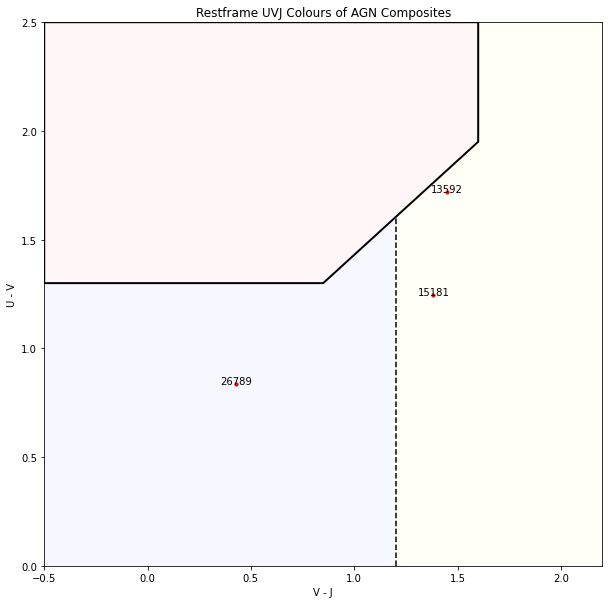

In [611]:
# Now we can plot these in UVJ space, including their relevant labels, and UV/VJ positions
from adjustText import adjust_text

plt.figure(figsize=(10, 10))

plt.scatter(vj_colours, uv_colours, c='r', s=10)

annotations = []

# Annotate points with text and adjust for collisions
texts = []
for i, txt in enumerate(new_objname_list):
    txt = f"{txt}" #({vj_colours[i]:.2f}, {uv_colours[i]:.2f})"
    texts.append(plt.text(vj_colours[i], uv_colours[i], txt, ha='center'))

# Adjust text to avoid collisions
#adjust_text(texts)

plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours of AGN Composites")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])

# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# output the plot, and save it
plt.savefig('outputs/UVJPlots/RecalculatedUVJ_Positions.png')

plt.show()



In [ ]:
# # Now we can plot these in UVJ space, including their relevant labels, and UV/VJ positions

# plt.figure(figsize=(10, 10))

# plt.scatter(vj_colours, uv_colours, c='r', s=10)

# # Adjust text to avoid collisions
# adjust_text(texts)

# plt.ylabel('U - V')
# plt.xlabel('V - J')
# plt.title("Restframe UVJ Colours of AGN Composites")
# plt.xlim([-0.5, 2.2])
# plt.ylim([0, 2.5])

# # Define paths for selections
# path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
# path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
# path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# # Add patches for selections
# plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
# plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
# plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# # Add vertical line
# plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)


# plt.show()

In [ ]:

df = uv_vj_df
df


,ID,UV,VJ
0,13592,1.720526,1.448883
1,15181,NaN,NaN
2,26789,NaN,NaN


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


Empty DataFrame
Columns: [ID, UV, VJ]
Index: []
Empty DataFrame
Columns: [ID, UV, VJ]
Index: []


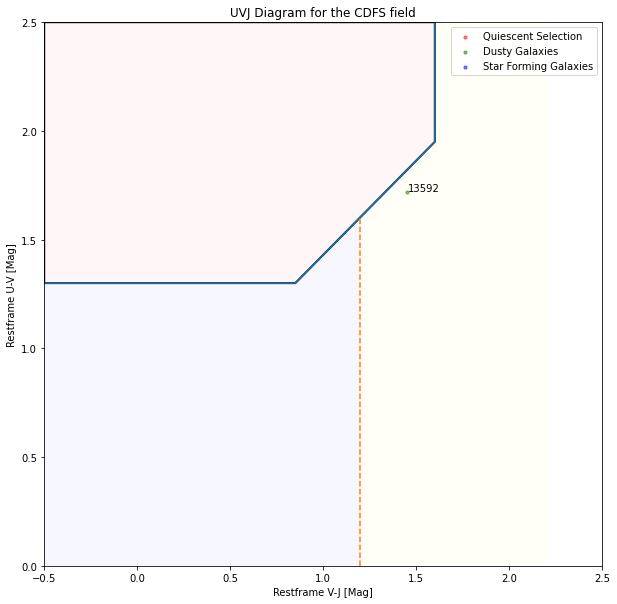

In [ ]:

# Plot the UVJ diagram
plt.figure(figsize=(10, 10))

x = df['VJ']
y = df['UV']
id = df['ID']

xmax = 2.5
ymax = 2.5
xmin = -0.5
ymin = 0

# Set the plotting limits
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Define the points for a quiescent galaxy selection
x_points = [-0.5, 0.85, 1.6, 1.6]
y_points = [1.3, 1.3, 1.95, 2.5]

# Plot the points
plt.plot(x_points, y_points, linestyle='-')

# Interpolate the y-value at x=1.2
x_target = 1.2
y_target = np.interp(x_target, x_points, y_points)

# Plot the interpolated point, this separates everything on the right as dusty galaxies,
# and everything on the left as star-forming galaxies
plt.plot([x_target, x_target], [0, y_target], linestyle='--')

quiescent_x = [-0.5, 0.85, 1.6, 1.6, xmin, xmin]
quiescent_y = [1.3, 1.3, 1.95, 2.5, ymax, 1.3]
# We want to make a wedge selection for the Quiescent Selection of Galaxies
points = np.column_stack([x, y])
verts = np.array([quiescent_x, quiescent_y]).T
path = mpath.Path(verts)


# Define the path for point selection
#selected_path = mpath.Path([(2, 3), (6, 4), (8, 2), (2, 1), (2, 3)])  # Example path, replace with your own

# Use path.contains_points to get a boolean array
points_inside_selection = path.contains_points(np.column_stack([x, y]))



dusty_condition = (points[:, 0] > x_target) & (~points_inside_selection)
star_forming_condition = (points[:, 0] < x_target) & (~points_inside_selection)



# Filter the DataFrame using the boolean array
selected_df = df[points_inside_selection] # For quiescent, clean later

# Mark dusty, and star-forming galaxies
df.loc[dusty_condition, 'GalaxyType'] = 2
df.loc[star_forming_condition, 'GalaxyType'] = 1




print(selected_df)
#print(unselected_df)

# Now we can easily select the quiescent galaxies and set the galaxy type to quiescent - 0 or starforming 1.
print(selected_df)
selected_ids = selected_df['ID']
df.loc[df['ID'].isin(selected_ids), 'GalaxyType'] = 0 # This is what makes the selection happen



# Try do the same for the unselected galaxies, noting that the unselected galaxies with x and y > 1.2 are dusty galaxies, and the rest are star-forming galaxies
#unselected_ids = unselected_df['id']




# Sort the quiescent and non-quiescent galaxies
quiescent_points = points[path.contains_points(points)]
# Find the points from here to categorise dusty, and star-forming galaxies
non_quiescent_points = points[~path.contains_points(points)]
dusty_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] > x_target]
star_forming_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] < x_target]


#print(non_quiescent_points[0][0])

#print(y)
# Plot the selected points
#plt.scatter(x, y, s=3, alpha=0.5, label='Not Quiescent Selection')
plt.scatter(quiescent_points[:, 0], quiescent_points[:, 1], c='r', s=10, alpha=0.5, label='Quiescent Selection')
plt.scatter(dusty_galaxies_points[:, 0], dusty_galaxies_points[:, 1], c='g', s=10, alpha=0.5, label='Dusty Galaxies')
plt.scatter(star_forming_galaxies_points[:, 0], star_forming_galaxies_points[:, 1], c='b', s=10, alpha=0.5, label='Star Forming Galaxies')

# Plot the names for the selected galaxies, in each reigon
text = []
for i in range(len(df)):
   text.append(plt.text(df.iloc[i]['VJ'], df.iloc[i]['UV'], df.iloc[i]['ID']))
adjust_text(text)



plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))


plt.xlabel('Restframe V-J [Mag]')
plt.ylabel('Restframe U-V [Mag]')
plt.title('UVJ Diagram for the CDFS field')
plt.legend()
plt.show()


In [ ]:
df

,ID,UV,VJ,GalaxyType
0,13592,1.720526,1.448883,2.0
1,15181,NaN,NaN,NaN
2,26789,NaN,NaN,NaN


In [ ]:
# Finally export the dataframe to a csv, containing the recalculated UVJ positions and galaxy type
def save_csv_with_numbered_name(df, save_path, file_name):
    # Check if the file already exists
    if os.path.isfile(os.path.join(save_path, f"{file_name}.csv")):
        # Append a number until a unique file name is found
        i = 1
        while os.path.isfile(os.path.join(save_path, f"{file_name}_{i}.csv")):
            i += 1
        file_name = f"{file_name}_{i}"
    
    # Save the DataFrame to CSV with the updated file name
    df.to_csv(os.path.join(save_path, f"{file_name}.csv"), index=False)
    print(f"CSV file saved as {file_name}.csv")

In [ ]:
save_csv_with_numbered_name(df, 'Eazy Template Extractions', 'RecalculatedUVJids')

CSV file saved as RecalculatedUVJids_9.csv
